<center><h1>Finite Differencing in Python</h1></center>

<center>Marin Lauber, 2019</center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy import sparse
try:
    plt.style.use("jupyter")
except OSError:
    print("Using default ploting style")

## What is the best method?

---

In [3]:
def cd2(a, dx):
    """
    Takes the first derivative of a discrete periodic field a
    using second-order central difference scheme
    
    f(i)' = (f(i+1) - f(i-1)) / 2dx
    
    """
    
    # avoid dividing
    alpha = 1./ (2. * dx)
        
    # storage array
    xd2 = np.empty_like(a)
    
    # interior points
    xd2[1:-1] = alpha * (a[2:] - a[:-2])
    
    # boundary points
    xd2[0]    = alpha * (a[1] - a[-1])
    xd2[-1]   = alpha * (a[0] - a[-2])
    
    return xd2

In [4]:
def cd2_roll(a, dx):
    
    # avoid dividing
    alpha = 1./ (2 * dx)
    
    # differentiate by rolling arrays
    xd2 = alpha * (np.roll(a, -1) - np.roll(a, +1))
    
    return xd2

In [18]:
def cd2_conv(a, dx):
    """
    Takes the first derivative of a discrete periodic field a
    using second-order central differencing
    """
    
    # avoid dividing
    alpha = 1./ dx
        
    # convolution kernel
    kernel = np.array([1, -1])
    
    # convolve to differentiate
    xd2 = alpha * np.convolve(a, kernel, "same")
    
    return xd2

In [19]:
def spectral(a, dx):
    """
    Takes the first derivative of a discrete periodic field a
    using Fourier spectral colocation method
    
    """
    # length of array
    N = len(a)
    L = N * dx

    # wavenumber
    kx = np.fft.rfftfreq(N) * N * 2 * np.pi / L

    # transform, differentiate, transform back
    four = np.fft.irfft(1j* kx * np.fft.rfft(a))
    
    return four

In [20]:
x, dx = np.linspace(0, 2*np.pi, 64, endpoint=False, retstep=True)
f = np.cos(x)
df = -np.sin(x)

In [21]:
%timeit cd2(f, dx)

5.59 µs ± 703 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%timeit cd2_roll(f, dx)

36.4 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%timeit cd2_conv(f, dx)

7.23 µs ± 197 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%timeit spectral(f, dx)

49.7 µs ± 822 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The Gaussian profile with a mean $\nu$ and a variance $\sigma^2$ is defined as

\begin{equation}
    \mathcal{N}(x | \nu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [12]:
def Gaussian(x, v=3., sigma=1.):
    return np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi)* sigma)

\begin{equation}
    \frac{d}{dx}\mathcal{N}(x | \nu, \sigma^2) = \frac{-(x-\nu)^2}{\sigma^3\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [13]:
def GaussianDer(x, v=3., sigma=1.):
    return -(x - v) * np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma**3)

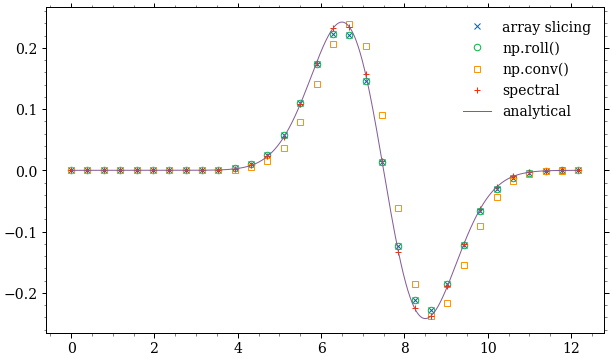

In [22]:
x, dx = np.linspace(0, 4*np.pi, 32, endpoint=False, retstep=True)
f = Gaussian(x,sigma=1.,v=7.5)
plt.plot(x, cd2(f, dx), 'x', markevery=1, label="array slicing")
plt.plot(x, cd2_roll(f, dx), 'o', mfc="None", markevery=1, label="np.roll()")
plt.plot(x, cd2_conv(f, dx), 's', mfc="None", markevery=1, label="np.conv()")
plt.plot(x, spectral(f, dx), '+', mfc="None", markevery=1, label="spectral")
x_sol = np.linspace(np.min(x), np.max(x), 1000, endpoint=False)
plt.plot(x_sol, GaussianDer(x_sol, v=7.5, sigma=1.), label="analytical")
plt.legend();

In [23]:
norm = np.ones((5, 4))
resolutions = np.array([32,64,128,256])
for j, res in enumerate(resolutions):
    x, dx = np.linspace(0, 4*np.pi, res, endpoint=False, retstep=True)
    f = Gaussian(x, v=7.5, sigma=1.)
    norm[0, j] = np.max(np.abs(cd2(f, dx)-GaussianDer(x, v=7.5, sigma=1.)))
    norm[1, j] = np.max(np.abs(cd2_roll(f, dx)-GaussianDer(x, v=7.5, sigma=1.)))
    norm[2, j] = np.max(np.abs(cd2_conv(f, dx)-GaussianDer(x, v=7.5, sigma=1.)))
    norm[3, j] = np.max(np.abs(spectral(f, dx)-GaussianDer(x, v=7.5, sigma=1.)))

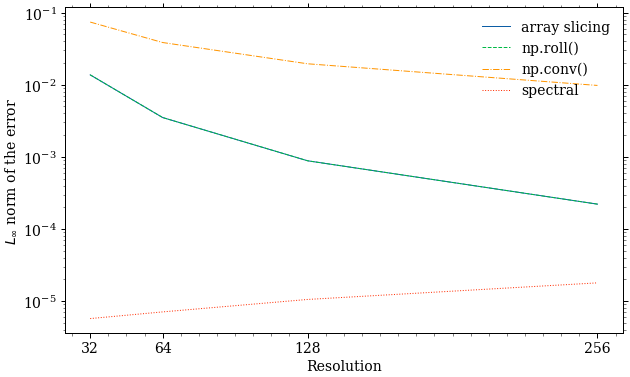

In [24]:
col = ['-', '--', '-.', ':']
lab = ["array slicing", "np.roll()", "np.conv()", "spectral"]
for i in range(4):
    plt.semilogy(resolutions, norm[i,:], label=lab[i], linestyle=col[i])
plt.xticks(resolutions)
plt.legend(); plt.xlabel("Resolution"); plt.ylabel("$L_{\infty}$ norm of the error")
plt.show()